Machine Learning aplicado a la predicción de precio de criptomonedas, utilizando valores anteriores de las principales critpomonedas, valores de índices de stocks, y trends de búsqueda. 

In [1]:
# Manipulación de datos
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt # Plots
import matplotlib.gridspec as gridspec
params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

# Keras
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.layers.core import Dense,Activation,Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from keras.callbacks import EarlyStopping
import time
import warnings
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from math import sqrt

#Manejo de archivos
import os
import tempfile
import shutil
import json

import DataManager as dm

c:\users\leandro\appdata\local\programs\python\python36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


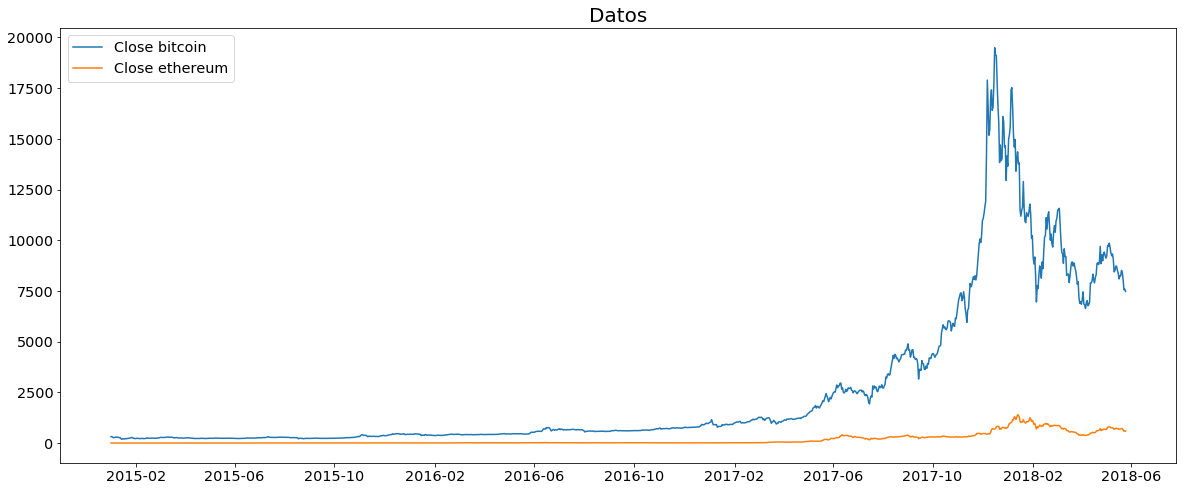

In [6]:
criptomonedas_posibles = ['bitcoin','ethereum','ripple','dash','litecoin',
                     'monero','ethereum-classic','nem','augur',                 
                     'litecoin','cardano','stellar','iota','tron',
                     'neo','dash','bitcoin-cash','eos','vechain',
                     'tether','qtum','omisego','icon','binance-coin',
                     'lisk','bitcoin-gold','bytecoin-bcn','nano','verge',
                     'zcash','aeternity','zilliqa']
top_criptomonedas = ['bitcoin','ethereum','ripple','dash','litecoin','monero','ethereum-classic','nem','augur']
stocks_names=['AAPL','FB','GOOG','GOOGL','IBM','INTC','MSFT','NFLX','ORCL','TSLA']
stockindex_names=['^IXIC','^RUT','^DJI','^GSPC']

'''cols = ['Close bitcoin','Open bitcoin','High bitcoin','Low bitcoin',
       'Close ethereum','Open ethereum','High ethereum','Low ethereum',
       'Close litecoin','Open litecoin','High litecoin','Low litecoin',
       'Close bitcoin-cash','Open bitcoin-cash','High bitcoin-cash','Low bitcoin-cash']'''
cols = ['Close bitcoin',
       'Close ethereum']

data = pd.read_csv('data/data.csv', usecols= ['Date'] + cols)
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
data = data[:'2018-05-25']

data.to_csv('data/data_btc.csv')

#Graficar la serie completa
plt.figure(figsize=(20,8))
for i in range(0,len(data.columns)):
    plt.plot(data.index, data[data.columns[i]], label=data.columns[i])
plt.legend(loc='upper left')
plt.title("Datos",fontsize=20)
#plt.savefig('baselines/naive_seriecompleta.png')
plt.show()

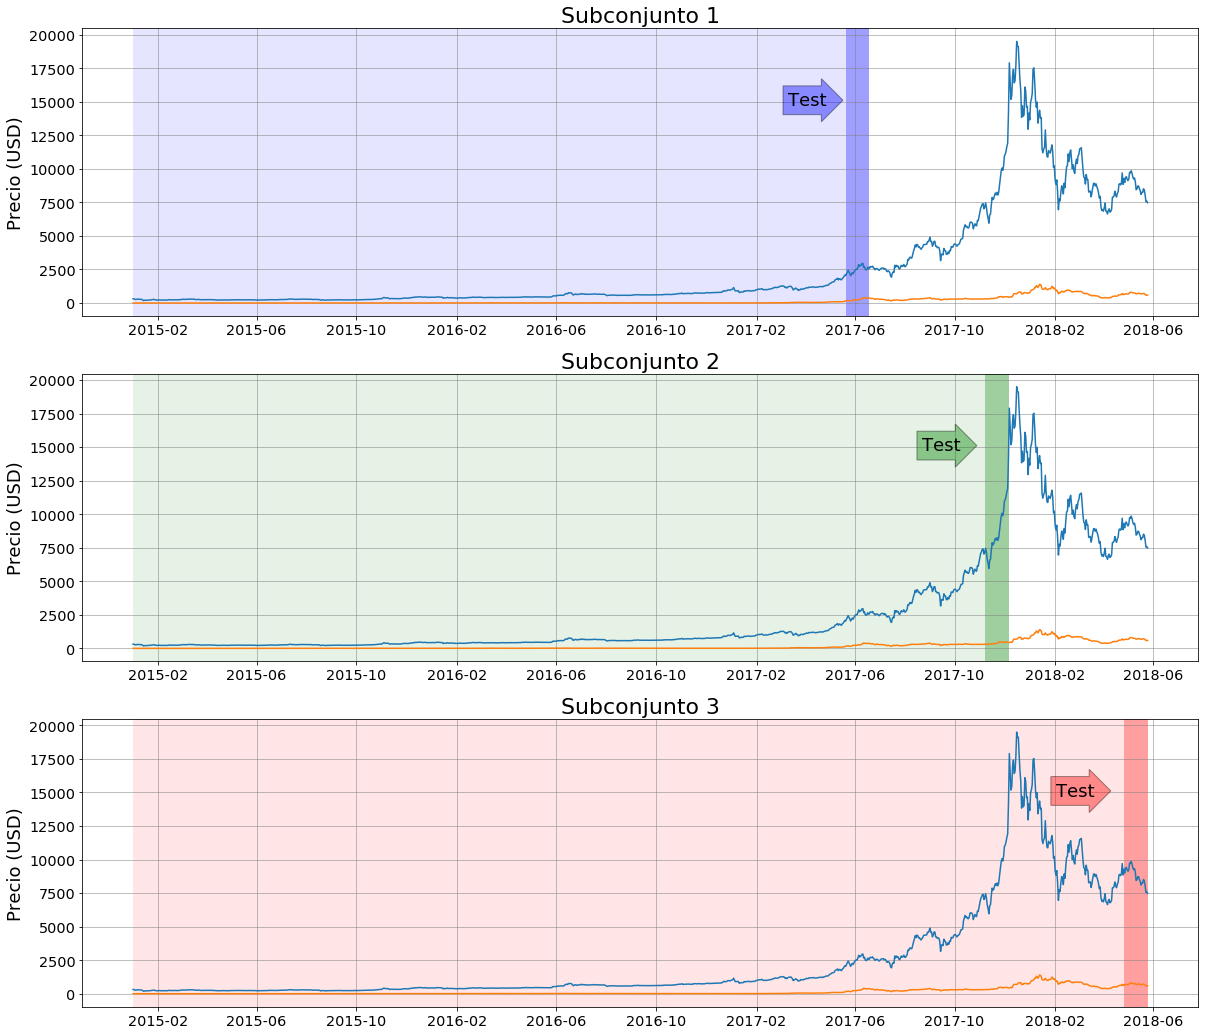

In [7]:
#Simulaciones
test_size = 30
ventana = [0,1,2]
futuro = [1]
moneda = 'bitcoin'
target = 'Close bitcoin'
N_tests = 3 #Cuantos tests se van a hacer con la serie
colores = ['r','g','b','c']
conf_data = {
    'moneda': moneda,
    'target': target,
    'N_tests': N_tests,
    'test_size':test_size,
    'futuro':futuro,
    'ventana':ventana
}

fig = plt.figure(figsize=(20,6*N_tests))
gs = gridspec.GridSpec(N_tests, 1, wspace=0, hspace=0.2); i=0
for n_test in range(N_tests-1,-1,-1):
    end=None if n_test == 0 else n_test*(-200+test_size)
    subconjunto = data[:end]; subconjunto_test = subconjunto[-test_size:]
    ax = plt.subplot(gs[i, 0:])
    ax.plot(data.index, data)  
    plt.axvspan(subconjunto.index[0], subconjunto.index[-1], facecolor=colores[n_test], alpha=0.1)
    plt.axvspan(subconjunto_test.index[0], subconjunto_test.index[-1], facecolor=colores[n_test], alpha=0.3)
    ax.text(0.65+i*0.12, 0.75, "Test", ha="center", va="center", size=18,transform=ax.transAxes, bbox= dict(boxstyle="rarrow,pad=0.3", fc=colores[n_test], alpha=0.4))
    plt.ylabel('Precio (USD)', fontsize=18)
    plt.title("Subconjunto " + str(i+1),fontsize=22)
    plt.grid(color='grey', linestyle='-', linewidth=0.5); i+=1

In [10]:
# Crear carpeta donde se almacenarán las predicciones        
if not os.path.exists("predicciones"):
    os.makedirs("predicciones") # Crear carpeta de predicciones
datasetfolder = "predicciones" + "/"  + moneda
if (os.path.exists(datasetfolder)):
    tmp = tempfile.mktemp(dir=os.path.dirname(datasetfolder))
    shutil.move(datasetfolder, tmp) # Mover el dir a una ubicacion temporal
    shutil.rmtree(tmp) # Eliminar la carpeta que existía
os.makedirs(datasetfolder)  

# Convertir el conjunto de datos como dos conjuntos x e y
def create_dataset(dataset,col_target,f):
    dataX, dataY = [], []
    for i in range(len(dataset)-f):  
        dataX.append(dataset[i,:])  #precio (BHC,ETH,LCT,XRP,...)
        dataY.append(dataset[i+f,col_target])  #precio BTC del dia futuro f
    return np.asarray(dataX), np.asarray(dataY)

# Convertir el conjunto de datos como dos conjuntos x e y, donde x no contiene al target
def create_dataset_sintarget(dataset,col_target,f):
    dataX, dataY = [], []
    dataset_sintarget = np.delete(dataset, col_target, 1)
    for i in range(len(dataset)-f):  
        dataX.append(dataset_sintarget[i,:])  #precio (BHC,ETH,LCT,XRP,...)
        dataY.append(dataset[i+f,col_target])  #precio BTC del dia futuro f
    return np.asarray(dataX), np.asarray(dataY)

def create_batches(dataset,targets,v):
    b = []
    t = []
    for i in range(len(dataset)-v):
        batch = dataset[i:i+v+1]
        b.append(batch)
        t.append(targets[i+v])
    return np.asarray(b),np.asarray(t)

prediccioncompleta =  data[[target]].copy() # Todas las predicciones en un dataframe (output de la simulacion)
for f in futuro:
        for v in ventana: 
                    dataset_name = 'f' + str(f) + 'v' + str(v)                  
                    prediccionxdataset = pd.DataFrame() # todos los subconjuntos de test en un dataframe
                    entrenamientos = []
                    for n_test in range(N_tests-1,-1,-1):
                        end=None if n_test == 0 else n_test*(-200+test_size)
                        dataset = data.copy()[:end]
                        prediccion_subset = dataset[[target]][-test_size:].copy() #Dataframe con una sola columma: el precio real (luego se añade la prediccion)
              
                        # Separar el datset en x e y (predicción para el día f)
                        x,y = create_dataset(np.asarray(dataset),dataset.columns.get_loc(target),f)
                        y = y.reshape(-1,1)
                        
                        # Separar x,y en conjuntos de entrenamiento y testeo (test_size+v para poder hacer ventanas de timesteps después de escalar y que siempre queden 30 puntos de predicción en test)
                        train_x, train_y = x[:-test_size], y[:-test_size]
                        test_x, test_y = x[-test_size-v:], y[-test_size-v:]
                        
                        '''print("train_x");print(train_x.shape);print(train_x);
                        print("train_y");print(train_y.shape);print(train_y);
                        print("test_x");print(test_x.shape);print(test_x)
                        print("test_y");print(test_y.shape);print(test_y)'''
                        
                        # Normalización: Escalar los datos entre [0,1]. Hay que escalar con respecto al training set, como si el test set no estuviera.
                        scalerX = preprocessing.MinMaxScaler(feature_range = (0,1)).fit(train_x)
                        train_x_scaled = scalerX.transform(train_x)
                        test_x_scaled = scalerX.transform(test_x)
                        scalerY = preprocessing.MinMaxScaler(feature_range = (0,1)).fit(train_y)
                        train_y_scaled = scalerY.transform(train_y)
                        test_y_scaled = scalerY.transform(test_y)        
                        
                        # Crear batches de v timesteps (ventana)
                        input_train,target_train = create_batches(train_x_scaled,
                                                                  train_y_scaled,v)
                        input_test,target_test = create_batches(test_x_scaled,
                                                                test_y_scaled,v)
                        '''
                        input_train,target_train = create_batches(scalerX.inverse_transform(train_x_scaled),
                                                                  scalerY.inverse_transform(train_y_scaled),v)
                        input_test,target_test = create_batches(scalerX.inverse_transform(test_x_scaled),
                                                                scalerY.inverse_transform(test_y_scaled),v)
                       
                        print("input train");print(input_train.shape);print(input_train);
                        print("target train");print(target_train.shape);print(target_train)
                        print("input test");print(input_test.shape);print(input_test);
                        print("target test");print(target_test.shape);print(target_test)'''
                    
                        #Construir red neuronal y entrenarla
                        model = Sequential()
                        model.add(LSTM(units = 64, # dropout=0, 
                                           input_shape=(input_train.shape[1], 
                                                        input_train.shape[2]),
                                      return_sequences=False, activation = 'tanh'))
                        model.add(Dense(units = 1, activation = 'linear'))
                        model.compile(optimizer = 'adam', loss = 'mean_squared_error')
                        early_stopping_monitor = EarlyStopping(monitor='val_loss',patience=10,verbose=1) # Stop loss después de *patience* epochs consecutivos sin mejora
                        history = model.fit(input_train, target_train, validation_split=0.05,
                                            batch_size=32, epochs = 300, callbacks=[early_stopping_monitor], 
                                            shuffle=False,verbose=1)  
                        
                        # Dataframe de entrenamiento
                        training_history = pd.DataFrame() 
                        training_history = pd.concat([training_history, pd.DataFrame(data=history.history['loss'], columns=[dataset_name +'_loss'])], axis=1)
                        training_history = pd.concat([training_history, pd.DataFrame(data=history.history['val_loss'], columns=[dataset_name + '_val_loss'])], axis=1)
                        training_history.to_csv(datasetfolder + '/entrenamiento_' + dataset_name + '('+ str(n_test+1) +').csv')
                        print('Entrenamiento ' + dataset_name + '('+ str(n_test+1) +') completo.')
                        entrenamientos.append(training_history)   
                              
                        #Predicción de testeo
                        predicted_scaled = model.predict(input_test)
                        predicted_scaled = predicted_scaled.reshape(-1,1)
                        predicted = scalerY.inverse_transform(predicted_scaled)
                        print(predicted)
                                                     
                        # Dataframe de prediccion del subset  
                        prediccion_subset[dataset_name] = predicted
                        # Agregar la prediccion del subset (30 dias) al dataframe con la prediccion completa (3 tests)
                        prediccionxdataset = prediccionxdataset.append(prediccion_subset)
                        
                    print('Predicción ' + dataset_name + ' completa.')     
                    # Agregar la predicción completa (3 tests) al dataframe con TODAS las predicciones para la moneda
                    prediccioncompleta = pd.merge(prediccioncompleta,prediccionxdataset.drop(columns=[target]),how="left",left_index=True,right_index=True)

print("Simulación completa.")
print(prediccioncompleta)
prediccioncompleta.to_csv(datasetfolder + '/' + moneda +'.csv')

with open(datasetfolder + '/conf.json', 'w') as outfile:
    json.dump(conf_data, outfile)

Train on 826 samples, validate on 44 samples
Epoch 1/300
826/826 [==============================] - 3s 4ms/step - loss: 0.0246 - val_loss: 0.2752
Epoch 2/300
826/826 [==============================] - 0s 157us/step - loss: 0.0136 - val_loss: 0.1838
Epoch 3/300
826/826 [==============================] - 0s 165us/step - loss: 0.0127 - val_loss: 0.1394
Epoch 4/300
826/826 [==============================] - 0s 189us/step - loss: 0.0121 - val_loss: 0.1128
Epoch 5/300
826/826 [==============================] - 0s 180us/step - loss: 0.0108 - val_loss: 0.0909
Epoch 6/300
826/826 [==============================] - 0s 144us/step - loss: 0.0095 - val_loss: 0.0706
Epoch 7/300
826/826 [==============================] - 0s 161us/step - loss: 0.0082 - val_loss: 0.0521
Epoch 8/300
826/826 [==============================] - 0s 175us/step - loss: 0.0069 - val_loss: 0.0358
Epoch 9/300
826/826 [==============================] - 0s 177us/step - loss: 0.0057 - val_loss: 0.0222
Epoch 10/300
826/826 [========

988/988 [==============================] - 0s 139us/step - loss: 4.3418e-04 - val_loss: 0.0095
Epoch 51/300
988/988 [==============================] - 0s 140us/step - loss: 4.1948e-04 - val_loss: 0.0090
Epoch 52/300
988/988 [==============================] - 0s 160us/step - loss: 4.0494e-04 - val_loss: 0.0085
Epoch 53/300
988/988 [==============================] - 0s 159us/step - loss: 3.9050e-04 - val_loss: 0.0080
Epoch 54/300
988/988 [==============================] - 0s 154us/step - loss: 3.7620e-04 - val_loss: 0.0076
Epoch 55/300
988/988 [==============================] - 0s 192us/step - loss: 3.6208e-04 - val_loss: 0.0071
Epoch 56/300
988/988 [==============================] - 0s 159us/step - loss: 3.4809e-04 - val_loss: 0.0067
Epoch 57/300
988/988 [==============================] - 0s 146us/step - loss: 3.3431e-04 - val_loss: 0.0063
Epoch 58/300
988/988 [==============================] - 0s 138us/step - loss: 3.2073e-04 - val_loss: 0.0059
Epoch 59/300
988/988 [===================

Epoch 23/300
1149/1149 [==============================] - 0s 155us/step - loss: 0.0012 - val_loss: 0.0011
Epoch 24/300
1149/1149 [==============================] - 0s 181us/step - loss: 0.0012 - val_loss: 0.0010
Epoch 25/300
1149/1149 [==============================] - 0s 177us/step - loss: 0.0011 - val_loss: 0.0010
Epoch 26/300
1149/1149 [==============================] - 0s 188us/step - loss: 0.0011 - val_loss: 9.8753e-04
Epoch 27/300
1149/1149 [==============================] - 0s 169us/step - loss: 0.0011 - val_loss: 9.6461e-04
Epoch 28/300
1149/1149 [==============================] - 0s 142us/step - loss: 0.0010 - val_loss: 9.4195e-04
Epoch 29/300
1149/1149 [==============================] - 0s 141us/step - loss: 9.8455e-04 - val_loss: 9.1956e-04
Epoch 30/300
1149/1149 [==============================] - 0s 163us/step - loss: 9.4791e-04 - val_loss: 8.9747e-04
Epoch 31/300
1149/1149 [==============================] - 0s 162us/step - loss: 9.1200e-04 - val_loss: 8.7568e-04
Epoch 32/3

1149/1149 [==============================] - 0s 140us/step - loss: 2.2524e-04 - val_loss: 4.4058e-04
Epoch 96/300
1149/1149 [==============================] - 0s 135us/step - loss: 2.2388e-04 - val_loss: 4.4051e-04
Epoch 97/300
1149/1149 [==============================] - 0s 142us/step - loss: 2.2259e-04 - val_loss: 4.4045e-04
Epoch 98/300
1149/1149 [==============================] - 0s 132us/step - loss: 2.2135e-04 - val_loss: 4.4040e-04
Epoch 99/300
1149/1149 [==============================] - 0s 135us/step - loss: 2.2020e-04 - val_loss: 4.4036e-04
Epoch 100/300
1149/1149 [==============================] - 0s 136us/step - loss: 2.1910e-04 - val_loss: 4.4035e-04
Epoch 101/300
1149/1149 [==============================] - 0s 140us/step - loss: 2.1811e-04 - val_loss: 4.4034e-04
Epoch 102/300
1149/1149 [==============================] - 0s 137us/step - loss: 2.1714e-04 - val_loss: 4.4038e-04
Epoch 103/300
1149/1149 [==============================] - 0s 136us/step - loss: 2.1631e-04 - val_

987/987 [==============================] - 0s 194us/step - loss: 1.7347e-04 - val_loss: 0.0011
Epoch 36/300
987/987 [==============================] - 0s 215us/step - loss: 1.6707e-04 - val_loss: 0.0011
Epoch 37/300
987/987 [==============================] - 0s 186us/step - loss: 1.6250e-04 - val_loss: 0.0011
Epoch 38/300
987/987 [==============================] - 0s 217us/step - loss: 1.5587e-04 - val_loss: 0.0011
Epoch 39/300
987/987 [==============================] - 0s 211us/step - loss: 1.5385e-04 - val_loss: 0.0011
Epoch 40/300
987/987 [==============================] - 0s 177us/step - loss: 1.4469e-04 - val_loss: 0.0011
Epoch 41/300
987/987 [==============================] - 0s 200us/step - loss: 1.4995e-04 - val_loss: 0.0011
Epoch 42/300
987/987 [==============================] - 0s 203us/step - loss: 1.3192e-04 - val_loss: 0.0010
Epoch 43/300
987/987 [==============================] - 0s 197us/step - loss: 1.6853e-04 - val_loss: 0.0011
Epoch 44/300
987/987 [===================

Epoch 48/300
1148/1148 [==============================] - 0s 154us/step - loss: 0.0027 - val_loss: 6.3109e-04
Epoch 49/300
1148/1148 [==============================] - 0s 184us/step - loss: 0.0038 - val_loss: 8.8812e-04
Epoch 50/300
1148/1148 [==============================] - 0s 166us/step - loss: 0.0048 - val_loss: 0.0031
Epoch 51/300
1148/1148 [==============================] - 0s 184us/step - loss: 0.0031 - val_loss: 9.5059e-04
Epoch 52/300
1148/1148 [==============================] - 0s 162us/step - loss: 5.1835e-04 - val_loss: 6.4344e-04
Epoch 53/300
1148/1148 [==============================] - 0s 172us/step - loss: 4.2004e-04 - val_loss: 6.2489e-04
Epoch 00053: early stopping
Entrenamiento f1v1(1) completo.
[[ 9434.225 ]
 [ 9179.586 ]
 [ 9295.346 ]
 [ 9310.331 ]
 [ 9540.113 ]
 [ 9491.463 ]
 [ 9354.722 ]
 [ 9349.166 ]
 [ 9707.102 ]
 [ 9980.094 ]
 [10050.356 ]
 [10035.848 ]
 [ 9779.458 ]
 [ 9575.6455]
 [ 9533.891 ]
 [ 9451.162 ]
 [ 9026.029 ]
 [ 8730.154 ]
 [ 8901.4375]
 [ 9018.83

1147/1147 [==============================] - 0s 213us/step - loss: 4.8799e-04 - val_loss: 7.9360e-04
Epoch 16/300
1147/1147 [==============================] - 0s 228us/step - loss: 4.9526e-04 - val_loss: 7.7425e-04
Epoch 17/300
1147/1147 [==============================] - 0s 243us/step - loss: 4.5849e-04 - val_loss: 8.1367e-04
Epoch 18/300
1147/1147 [==============================] - 0s 225us/step - loss: 5.2771e-04 - val_loss: 7.4665e-04
Epoch 19/300
1147/1147 [==============================] - 0s 222us/step - loss: 4.7427e-04 - val_loss: 9.7749e-04
Epoch 20/300
1147/1147 [==============================] - 0s 217us/step - loss: 9.2270e-04 - val_loss: 9.7385e-04
Epoch 21/300
1147/1147 [==============================] - 0s 219us/step - loss: 0.0016 - val_loss: 0.0010
Epoch 22/300
1147/1147 [==============================] - 0s 215us/step - loss: 0.0038 - val_loss: 0.0012
Epoch 23/300
1147/1147 [==============================] - 0s 205us/step - loss: 0.0067 - val_loss: 0.0059
Epoch 24/30

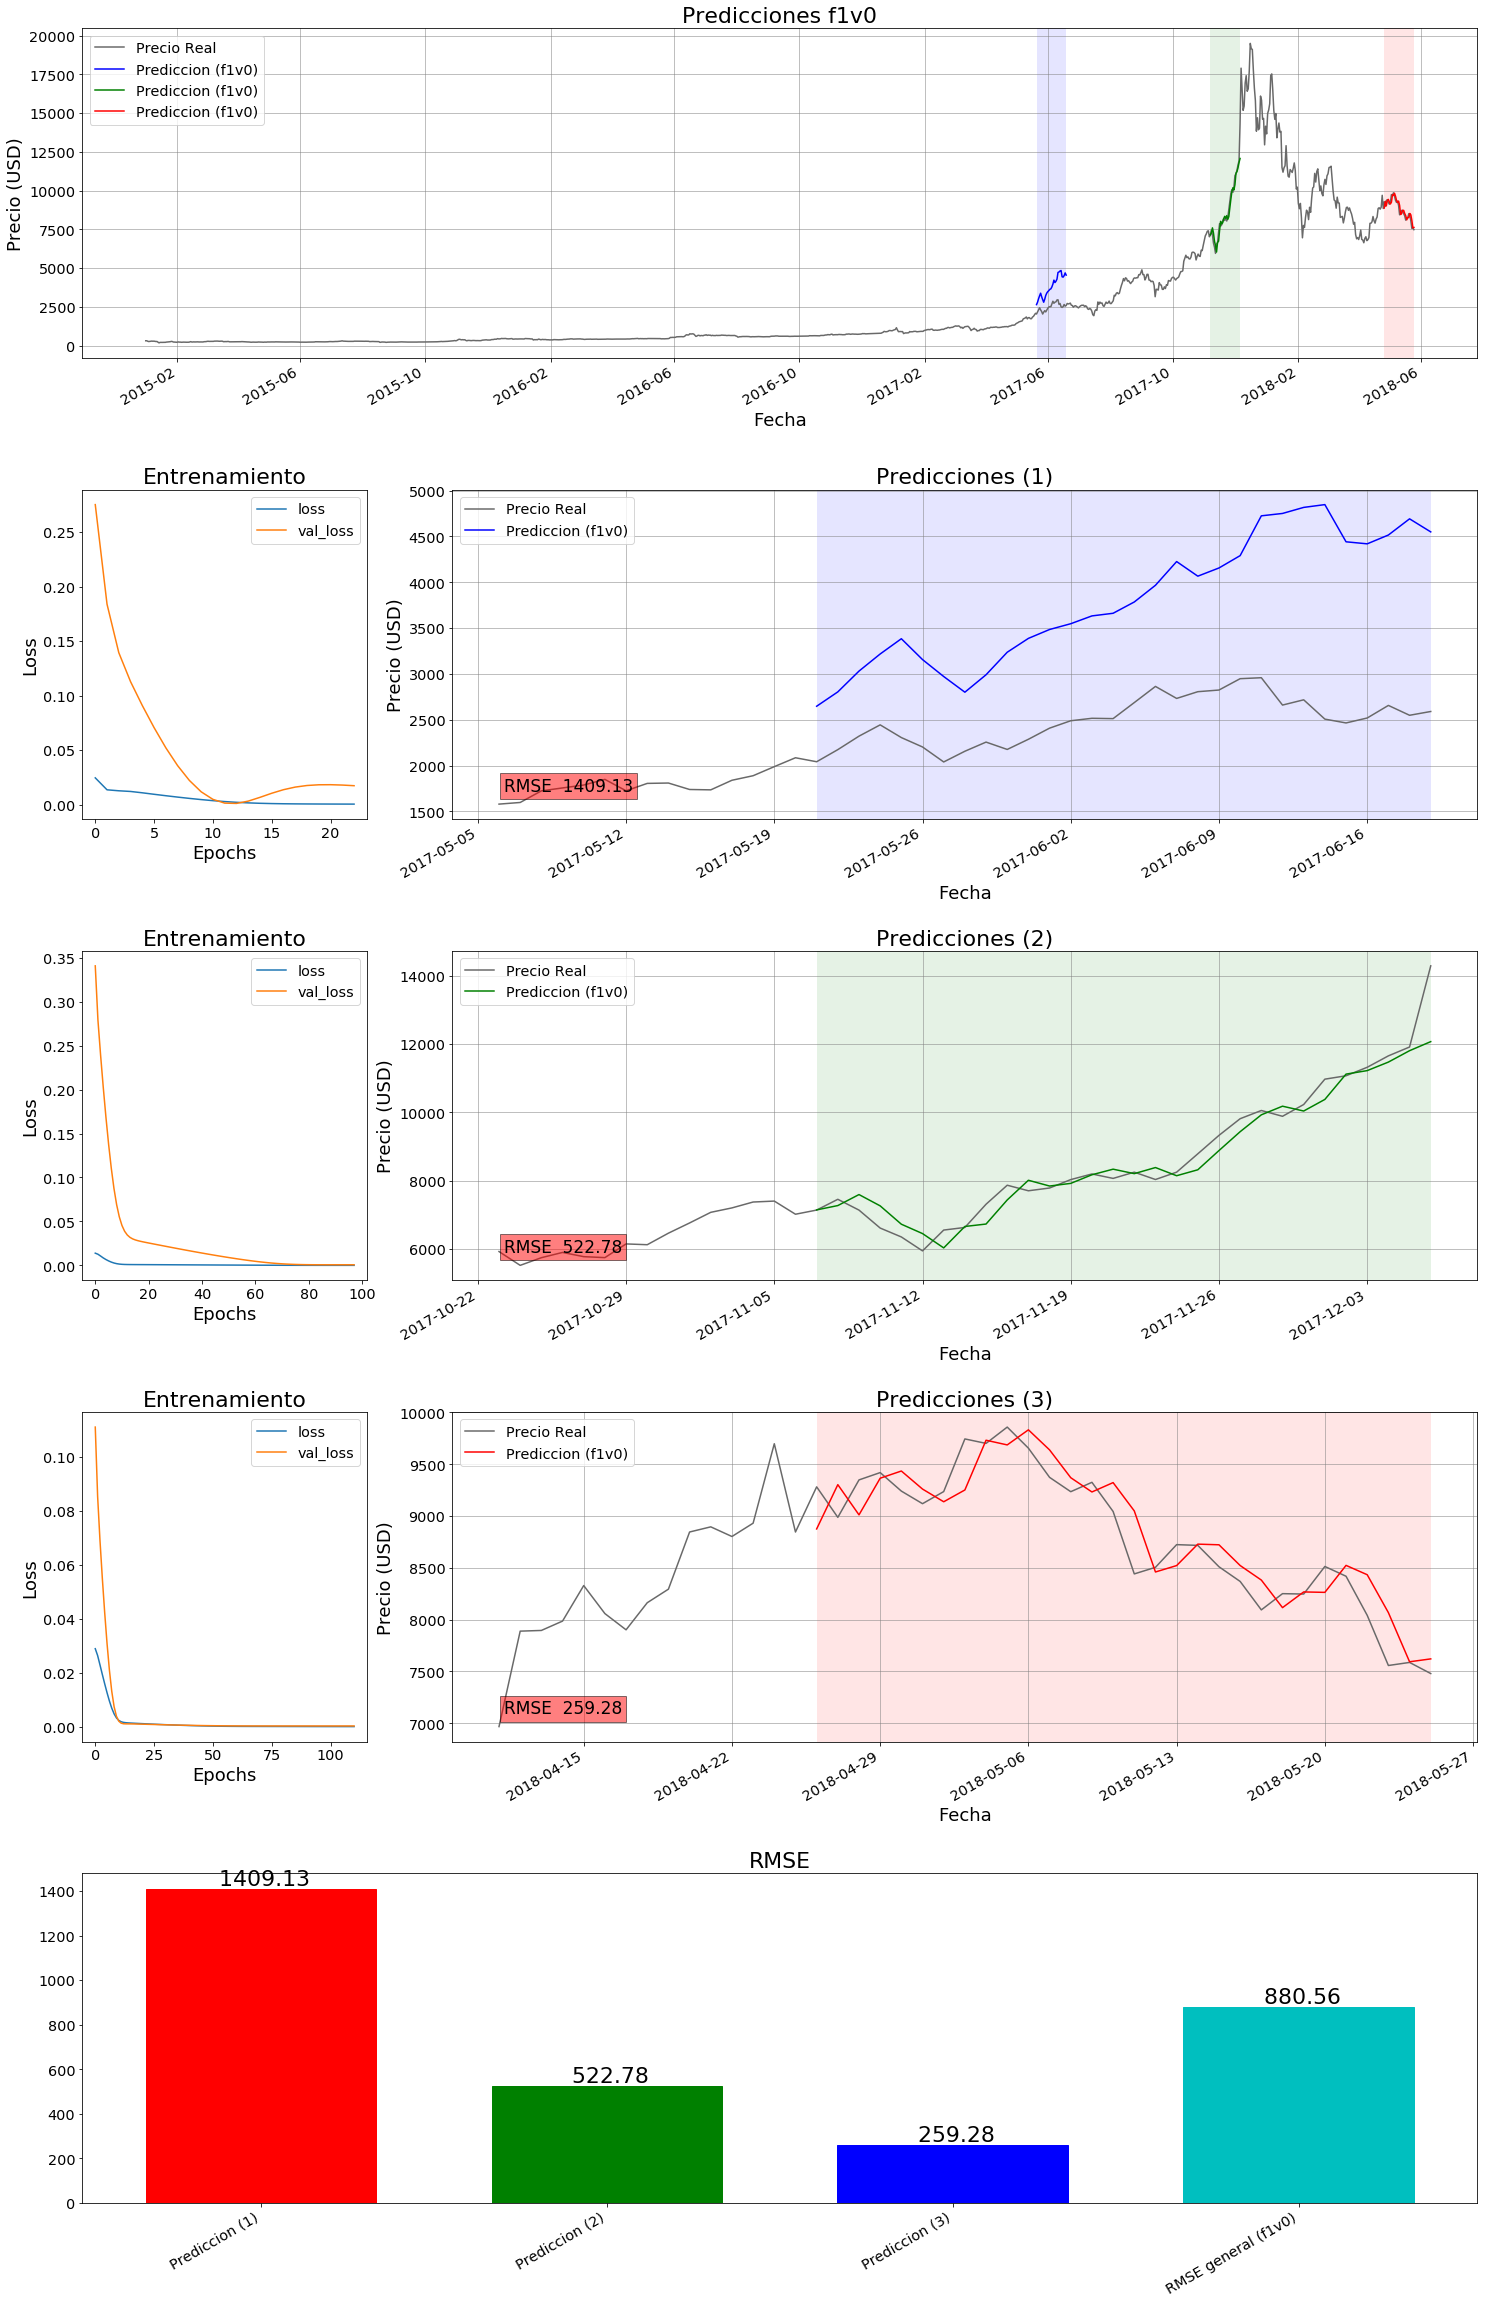

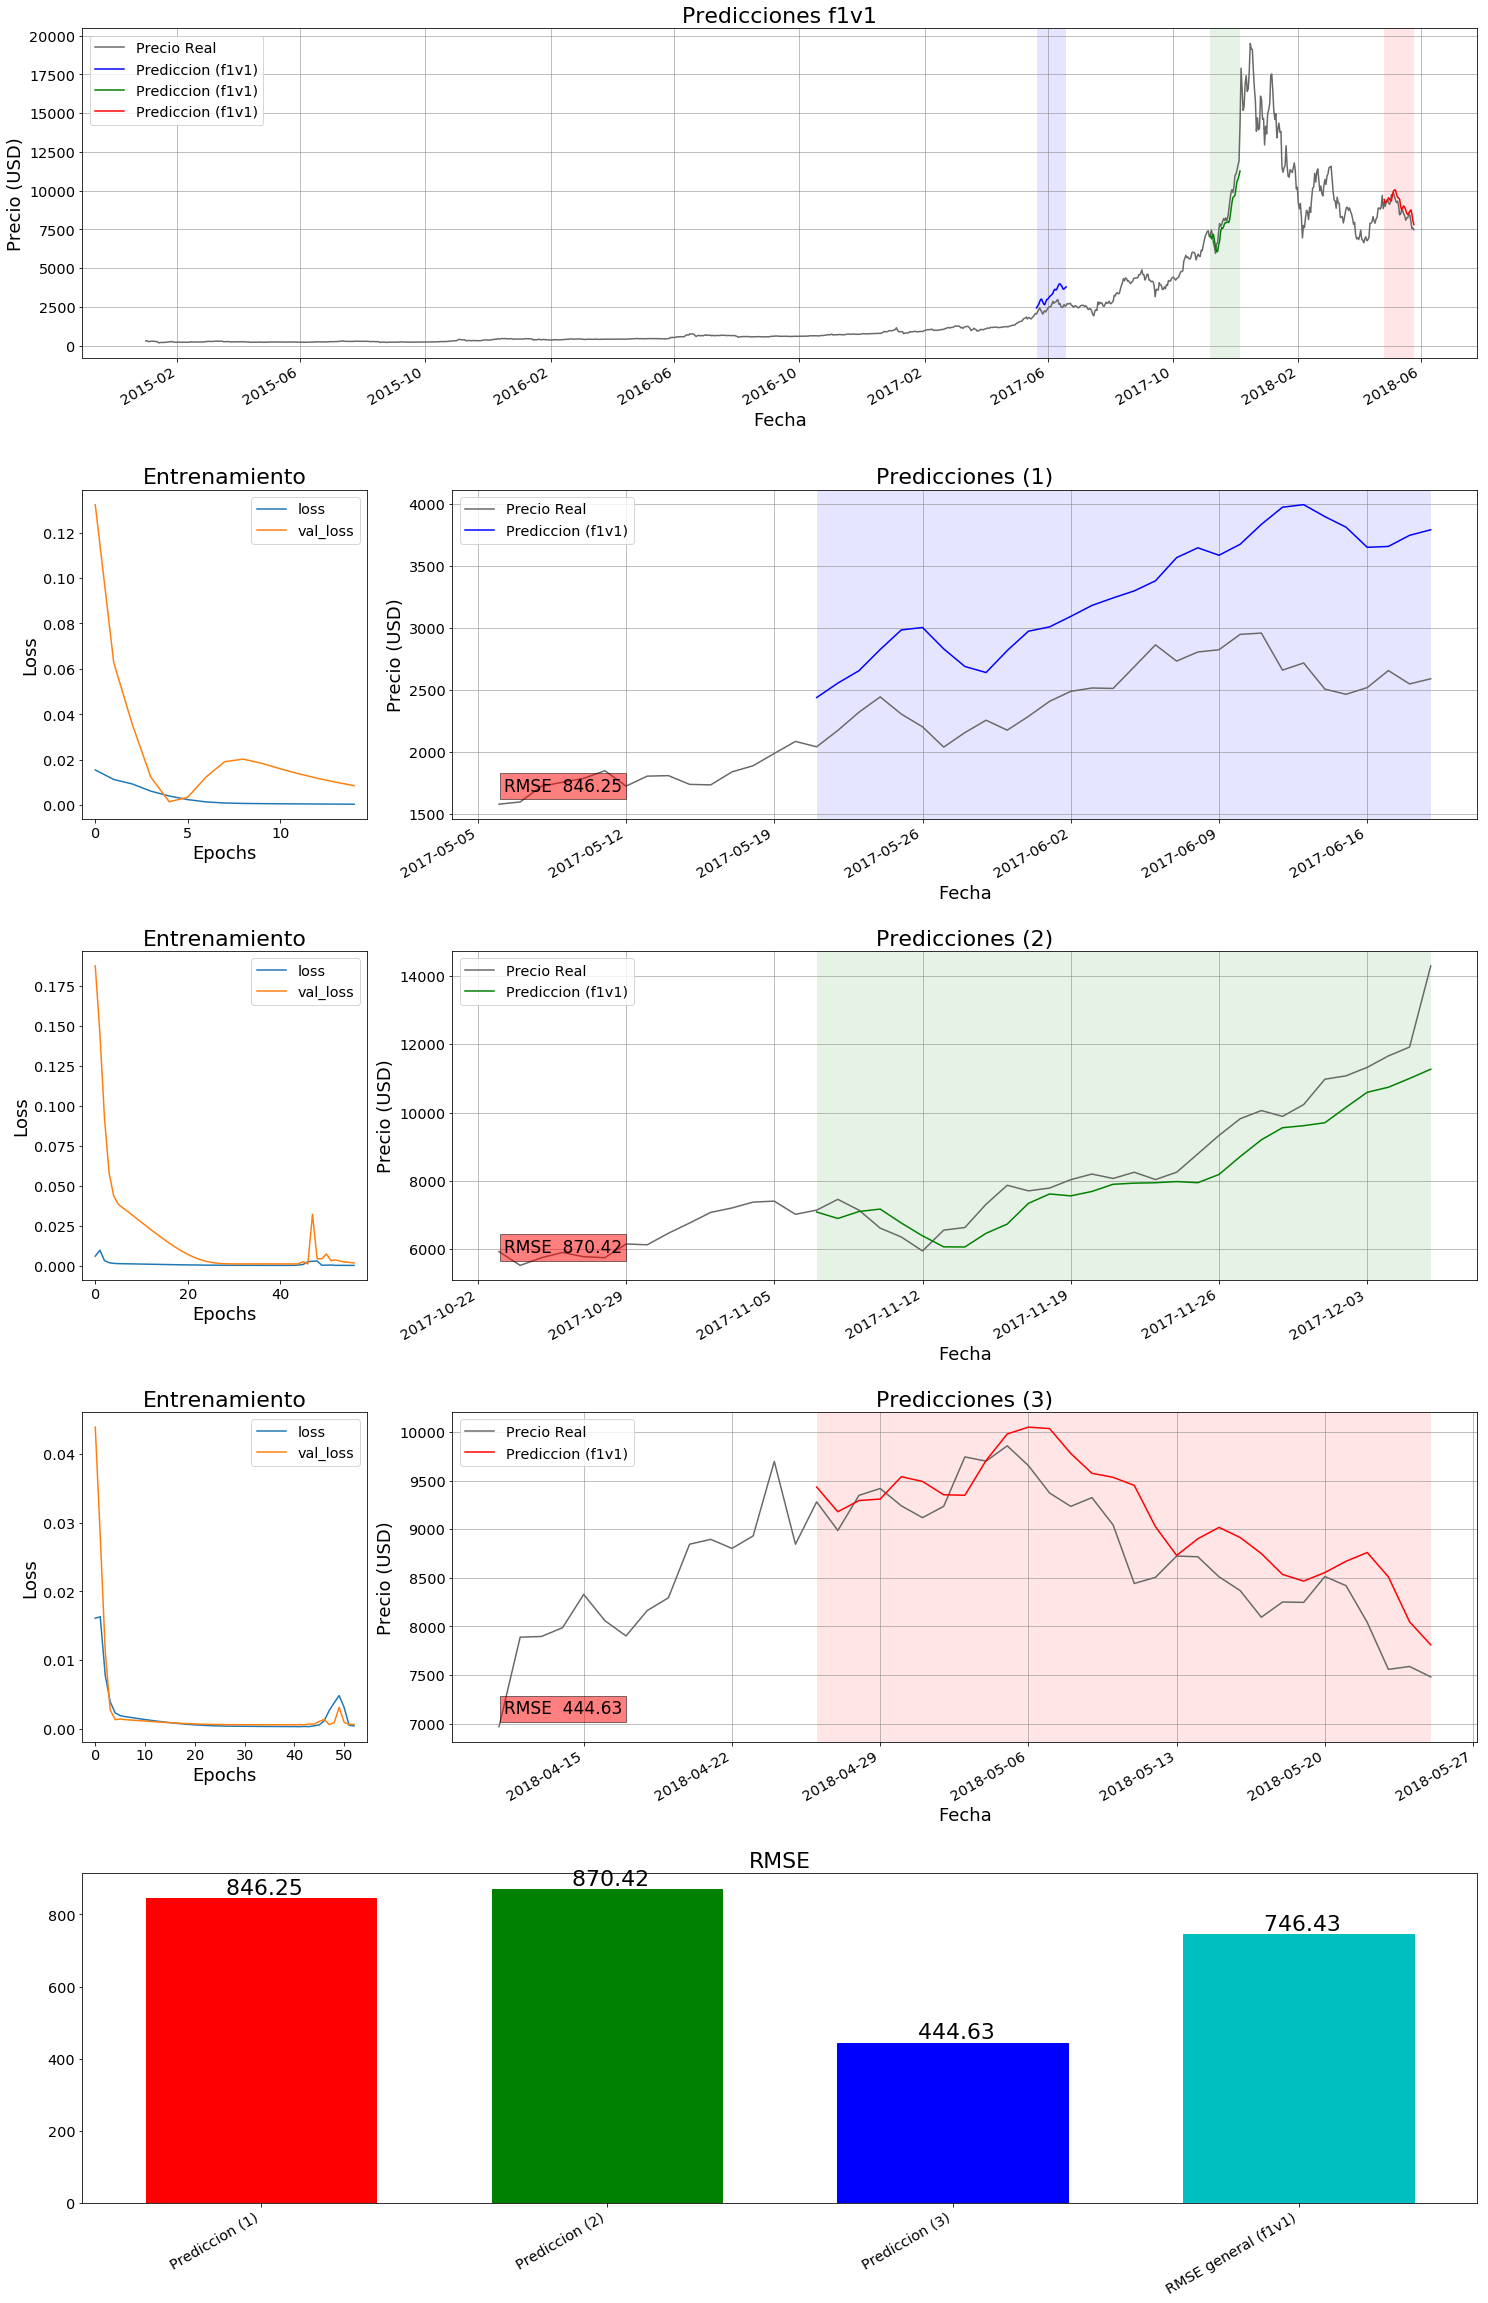

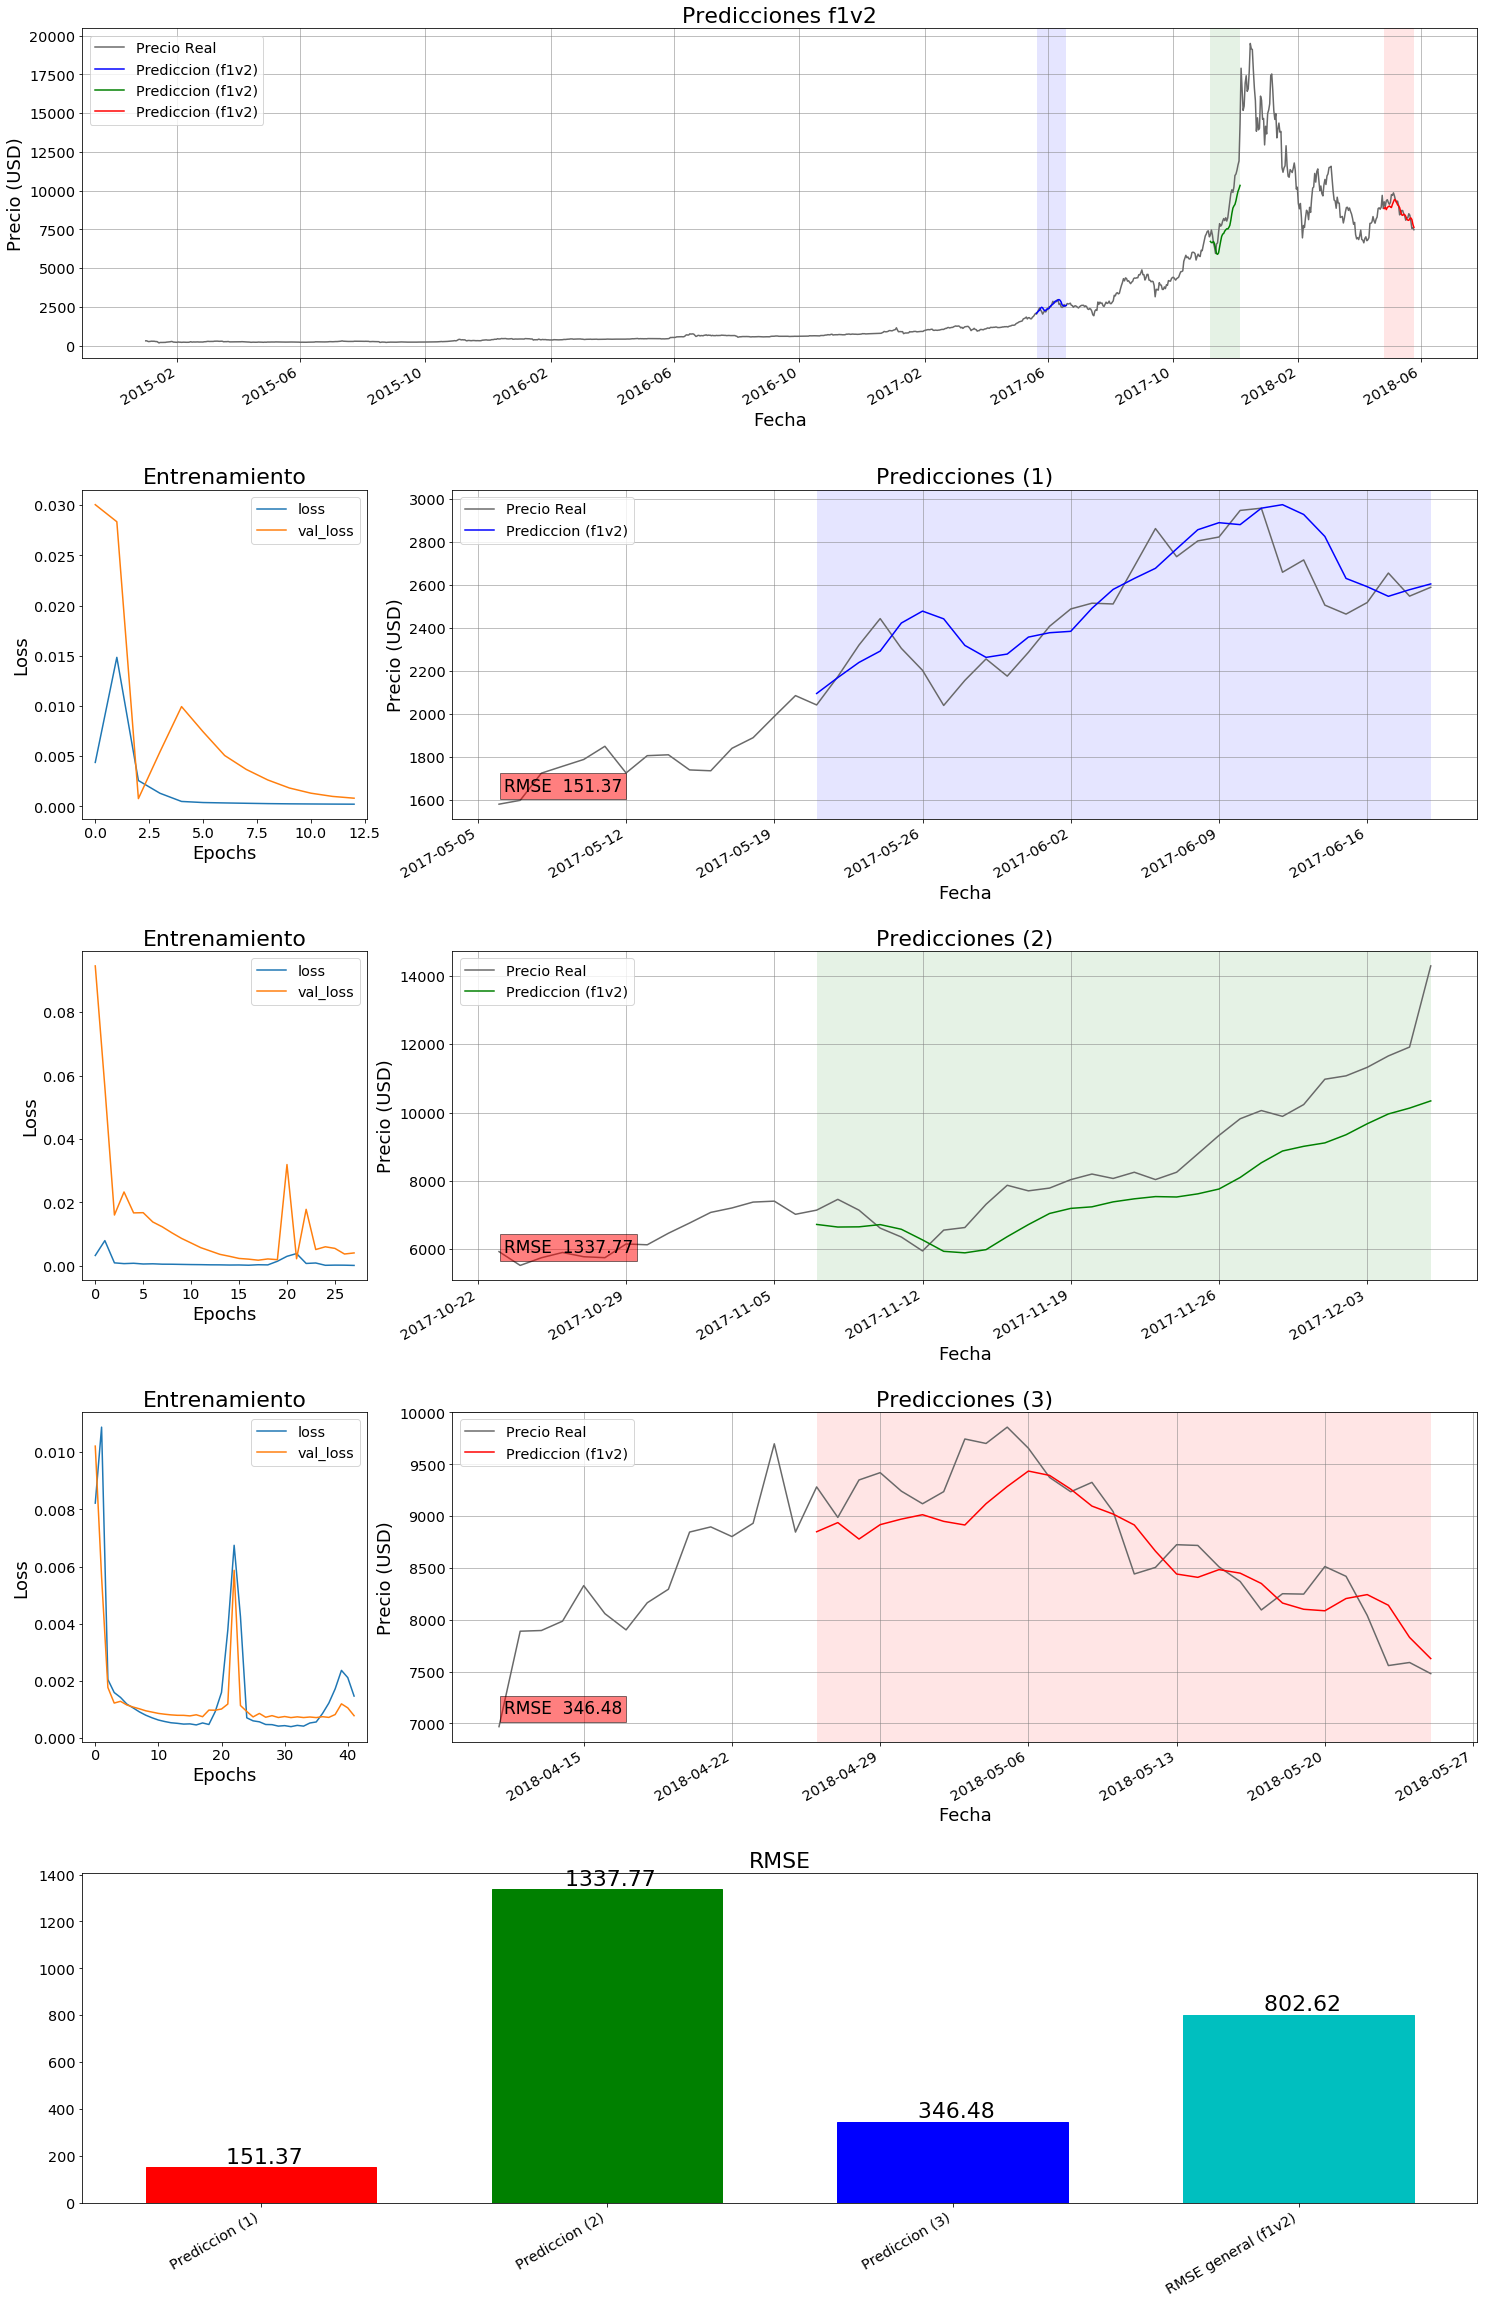

In [11]:
prediccion = prediccioncompleta
colores_test = ['r','g','b','c']
colores_futuro = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']

rmses = [[] for i in range(0,len(futuro))]; rmse_i =  0
for f in futuro:
        for v in ventana:  
                    dataset_name = 'f' + str(f) + 'v' + str(v)
                    i = 1
                    rmses_y = []
                    rmses_x = []
                    
                    #Visualización de resultados
                    fig = plt.figure(figsize=(25,10*4))
                    gs = gridspec.GridSpec(5, 4, wspace=0.3, hspace=0.4)

                    #Todas los subsets para un dataset
                    axPrediccionCompleta = plt.subplot(gs[0, 0:])
                    axPrediccionCompleta.plot(prediccion.index, prediccion[[target]], color='dimgray', label="Precio Real")  
                    axPrediccionCompleta.set_xlabel('Fecha', fontsize=18)
                    axPrediccionCompleta.set_ylabel('Precio (USD)', fontsize=18)
                    plt.xticks(rotation=30, ha="right")
                    axPrediccionCompleta.set_title("Predicciones " + dataset_name,fontsize=22)
                    axPrediccionCompleta.grid(color='grey', linestyle='-', linewidth=0.5) 
                    
                    prediccionxdataset = pd.DataFrame()
                    for n_test in range(N_tests-1,-1,-1):
                        end=None if n_test == 0 else n_test*(-200+test_size)
                        subset = prediccion[:end]
                        subset_moneda = subset[[target]]
                        subset_prediccion = subset[[dataset_name]][-test_size:]
                        prediccionxdataset = prediccionxdataset.append(
                            pd.concat([subset_moneda[-test_size:], subset_prediccion], axis=1))
                        
                        #Graficar la serie completa
                        axPrediccionCompleta.plot(subset_prediccion.index, subset_prediccion, color=colores_test[n_test], label='Prediccion (' + dataset_name + ')')
                        axPrediccionCompleta.axvspan(subset_prediccion.index[0], subset_prediccion.index[-1], facecolor=colores_test[n_test], alpha=0.1)  
                        axPrediccionCompleta.legend(loc='upper left')                        
                                                
                        #Cada entrenamiento
                        entrenamiento = pd.read_csv('predicciones/bitcoin/entrenamiento_' + dataset_name + '('+ str(n_test+1) +').csv',index_col =0)
                        axTraining = plt.subplot(gs[i, 0])
                        axTraining.plot(entrenamiento[entrenamiento.columns[0]], label='loss')
                        axTraining.plot(entrenamiento[entrenamiento.columns[1]], label='val_loss')
                        axTraining.set_xlabel('Epochs', fontsize=18)
                        axTraining.set_ylabel('Loss', fontsize=18)
                        axTraining.legend(loc='upper right')
                        axTraining.set_title("Entrenamiento", fontsize=22)
                        
                        #Cada prediccion   
                        axPrediccion = plt.subplot(gs[i, 1:])
                        axPrediccion.plot(subset_moneda.index[-45:], subset_moneda[-45:], color='dimgray', label="Precio Real")
                        axPrediccion.plot(subset_prediccion.index, subset_prediccion, color=colores_test[n_test],  label='Prediccion (' + dataset_name + ')')
                        axPrediccion.axvspan(subset_prediccion.index[0], subset_prediccion.index[-1], facecolor=colores_test[n_test], alpha=0.1)
                        axPrediccion.set_xlabel('Fecha', fontsize=18)
                        axPrediccion.set_ylabel('Precio (USD)', fontsize=18)
                        plt.xticks(rotation=30, ha="right")
                        axPrediccion.legend(loc='upper left')
                        axPrediccion.set_title("Predicciones (" + str(i) + ")",fontsize=22)
                        axPrediccion.grid(color='grey', linestyle='-', linewidth=0.5) 
                                                
                        #RMSE
                        rmse = sqrt(mean_squared_error(subset_moneda[-test_size:], subset_prediccion))
                        axPrediccion.text(0.05, 0.1, 'RMSE ' + str('% 6.2f' % rmse), 
                                            horizontalalignment='left',verticalalignment='center', 
                                            transform=axPrediccion.transAxes, fontsize=17, bbox=dict(facecolor='red', alpha=0.5))
                        rmses_y.append(rmse)
                        rmses_x.append('Prediccion ('+ str(i) +')')  

                        i+=1
                    
                   
                    rmse_general = sqrt(mean_squared_error(prediccionxdataset[prediccionxdataset.columns[0]], 
                                                           prediccionxdataset[prediccionxdataset.columns[1]]))
                    rmses_y.append(rmse_general)
                    rmses_x.append('RMSE general ('+ dataset_name +')')  
                    
                    #RMSE
                    width = 1/1.5
                    barplot = plt.subplot(gs[-1, :])
                    barplot = plt.bar(rmses_x, rmses_y, width)
                    col = 0;
                    for rect in barplot: # Valores en las barras
                        height = rect.get_height()
                        plt.text(rect.get_x() + rect.get_width()/2.0, height, '% 6.2f' % height,fontsize=22, ha='center',va='bottom')
                        rect.set_color(colores_test[col]); col+=1
                    plt.xticks(rotation=30, ha="right")
                    plt.title("RMSE", fontsize=22)

                    plt.savefig('predicciones/bitcoin/' + dataset_name + '.png', bbox_inches='tight')